In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.visualization import (ZScaleInterval, ImageNormalize)
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

In [2]:
cutout_dir = os.path.expandvars("$SCRATCH") + "/"
image_dir = "/home/anahoban/projects/rrg-kyi/astro/cfis/W3/"

In [3]:
#get tile ids
tile_list = open(image_dir + "tiles.list", "r")

# Only use tiles with all five channels
tile_list = open(image_dir + "tiles.list", "r")
tile_ids = []

for tile in tile_list:
    tile = tile[:-1] # Remove new line character
    channels = tile.split(" ")
    if len(channels) == 5: # Order is u,g,r,i,z
        tile_ids.append(channels[0][5:12]) # XXX.XXX id
tile_list.close()

In [4]:
hf = h5py.File(cutout_dir + "cutouts_filtered.h5", "r")

n_cutouts = 0
for i in range(5):
    print(i)
    n_cutouts += len(hf.get(tile_ids[i] + "/IMAGES"))
print(n_cutouts)


In [ ]:
n_valid = len(hf.get(tile_ids[12] + "/IMAGES"))

In [ ]:
# tiles for val and training
train_indices = range(2)
val_indices = [12]

In [ ]:
BATCH_SIZE = 256 #128
CUTOUT_SIZE = 128
N_EPOCHS = 8 #12
weights_cfis = np.zeros((BATCH_SIZE, CUTOUT_SIZE, CUTOUT_SIZE, 1))
weights_ps1 = np.zeros((BATCH_SIZE, CUTOUT_SIZE, CUTOUT_SIZE, 3))
weights_all = np.zeros((BATCH_SIZE, CUTOUT_SIZE, CUTOUT_SIZE, 5))

### Test weights:
#### trying to use half 1 and half 0.5 weights when training so that we get 1/2 the loss we'd get without any weights

In [8]:
test_weight = tf.concat((tf.ones((64,128,1)),0.5*tf.ones((64,128,1))), axis=0)

In [9]:
test_weight

<tf.Tensor: shape=(128, 128, 1), dtype=float32, numpy=
array([[[1. ],
        [1. ],
        [1. ],
        ...,
        [1. ],
        [1. ],
        [1. ]],

       [[1. ],
        [1. ],
        [1. ],
        ...,
        [1. ],
        [1. ],
        [1. ]],

       [[1. ],
        [1. ],
        [1. ],
        ...,
        [1. ],
        [1. ],
        [1. ]],

       ...,

       [[0.5],
        [0.5],
        [0.5],
        ...,
        [0.5],
        [0.5],
        [0.5]],

       [[0.5],
        [0.5],
        [0.5],
        ...,
        [0.5],
        [0.5],
        [0.5]],

       [[0.5],
        [0.5],
        [0.5],
        ...,
        [0.5],
        [0.5],
        [0.5]]], dtype=float32)>

In [21]:
def get_test_cutouts(index, n_cutouts, cutout_size, bands="cfis", start=0):
    n = 0
    if bands == "all":
        band_indices = [0, 1, 2, 3, 4]
        l = len(band_indices)
        sources = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        weights = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        
        
    elif bands == "cfis":
        band_indices = [0,2]
        l = len(band_indices)
        sources = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        weights = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        
    else: # PS1
        band_indices = [1, 3, 4]
        l = len(band_indices)
        sources = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        weights = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        
    img_group = hf.get(tile_ids[index] + "/IMAGES")
    wt_group = hf.get(tile_ids[index] + "/WEIGHTS")
    for i in range(start, len(img_group)):
        sources[n,:,:,:] = np.array(img_group.get(f"c{i}"))[:,:,band_indices]
        weights[n,:,:,:] = np.array(wt_group.get(f"c{i}"))[:,:,band_indices]
        n += 1
        if n == n_cutouts:
            #return sources #if no weights
            return np.concatenate((sources, weights),axis=-1) #if we train with weights

In [23]:
CUTOUT_SIZE = 128
test_index = 13
sources_test_cfis = get_test_cutouts(test_index, 50, CUTOUT_SIZE, "cfis")
#sources_test_ps1 = get_test_cutouts(test_index, 50, cutout_size, "ps1")
#sources_test_all = get_test_cutouts(test_index, 50, CUTOUT_SIZE)
sources_test_cfis.shape

(50, 128, 128, 4)

In [24]:
def get_cutouts(tile_indices, batch_size, cutout_size, bands="all"):
    ''' Input: hf file, tile indices, batch size, dimensions, band and bands
        Output: the img and weight cutouts for the test set as (batch_size, pix, pix, channels) '''
    b = 0 # counter for batch
    if bands == "all":
        band_indices = [0, 1, 2, 3, 4]
    elif bands == "cfis":
        band_indices = [0,2]
        l = len(band_indices)
    elif bands == "ps1":
        band_indices = [1, 3, 4]
    else:
        print('WARNING: unrecognized band')
        band_indices = [0]   
 
    l = len(band_indices)
    sources = np.zeros((batch_size, cutout_size, cutout_size, l))
    weights = np.zeros((batch_size, cutout_size, cutout_size, l))
    while True:
        for i in tile_indices:
            img_group = hf.get(tile_ids[i] + "/IMAGES")
            wt_group = hf.get(tile_ids[i] + "/WEIGHTS")
            n_cutouts = len(img_group)
            for n in range(n_cutouts):
                sources[b,:,:,:] = np.array(img_group.get(f"c{n}"))[:,:,band_indices]
                weights[b,:,:,:] = np.array(wt_group.get(f"c{n}"))[:,:,band_indices]
                b += 1
                if b == batch_size:
                    b = 0
                    #yield (sources,sources)# no weights
                    yield (np.concatenate((sources, weights), axis = -1), sources) #with weights

In [25]:
cut = get_cutouts([13], 128,128, bands = "cfis")

In [28]:
next(cut)

(array([[[[8.04293007e-02, 7.76483715e-01, 0.00000000e+00,
           0.00000000e+00],
          [8.30410719e-02, 7.76483715e-01, 0.00000000e+00,
           0.00000000e+00],
          [1.10115200e-01, 7.76483715e-01, 0.00000000e+00,
           0.00000000e+00],
          ...,
          [4.70003262e-02, 7.81290889e-01, 0.00000000e+00,
           5.98964252e-05],
          [5.24071530e-02, 7.71580577e-01, 0.00000000e+00,
           5.98964252e-05],
          [7.38356113e-02, 7.77984083e-01, 0.00000000e+00,
           5.98964252e-05]],
 
         [[7.23135099e-02, 7.76483715e-01, 0.00000000e+00,
           0.00000000e+00],
          [1.07432358e-01, 7.76483715e-01, 0.00000000e+00,
           0.00000000e+00],
          [6.92349747e-02, 7.76483715e-01, 0.00000000e+00,
           0.00000000e+00],
          ...,
          [9.76710171e-02, 7.76326180e-01, 0.00000000e+00,
           5.98964252e-05],
          [8.17602649e-02, 7.72885978e-01, 0.00000000e+00,
           5.98964252e-05],
          

In [29]:
def train_autoencoder(model, train_indices, val_indices, n_epochs, batch_size, cutout_size, bands="all"):
    n_cutouts_train = 0
    for i in train_indices:
        img_group = hf.get(tile_ids[i] + "/IMAGES")        
        n_cutouts_train += len(img_group)
    
    n_cutouts_val = 0    
    for i in val_indices:
        img_group = hf.get(tile_ids[i] + "/IMAGES")        
        n_cutouts_val += len(img_group)
    
    train_steps = n_cutouts_train // batch_size
    val_steps = n_cutouts_val // batch_size
    
    history = model.fit(get_cutouts(train_indices, batch_size, cutout_size, bands), 
                        epochs=n_epochs, steps_per_epoch=train_steps, 
                        validation_data=get_cutouts(val_indices, batch_size, cutout_size, bands), 
                        validation_steps=val_steps)
    return model, history

In [30]:
from tensorflow.keras.layers import Lambda
def create_autoencoder2(shape):
    input_all = keras.Input(shape=shape)
    weights = input_all[...,shape[-1]//2:]
    x = keras.layers.Conv2D(16, kernel_size=3, activation='relu', padding='same')(input_all)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)

    y = keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(input_all)
    y = keras.layers.BatchNormalization()(y)
    encoded = keras.layers.Add()([x,y])
    
    x = keras.layers.Conv2DTranspose(32, kernel_size=4, activation='relu', padding='same')(encoded)
    x = keras.layers.Conv2DTranspose(16, kernel_size=4, activation='relu', padding='same')(x)
    
    #weights
    decoded_img = keras.layers.Conv2D(shape[2] // 2, kernel_size=3, activation='linear', padding='same')(x)
    decoded_all = tf.concat([decoded_img, weights], axis = -1)
    
    #no weights
    #decoded_all = keras.layers.Conv2D(shape[2], kernel_size=3,activation='relu', padding = 'same')(x)                                  
    
    return keras.Model(input_all, decoded_all)

In [41]:
# tiles for val and training
train_indices = range(5)
val_indices = [12]
BATCH_SIZE= 256

In [32]:
tf.gather(sources_test_cfis,indices=[1], axis=-1)

<tf.Tensor: shape=(50, 128, 128, 1), dtype=float64, numpy=
array([[[[0.77648371],
         [0.77648371],
         [0.77648371],
         ...,
         [0.78129089],
         [0.77158058],
         [0.77798408]],

        [[0.77648371],
         [0.77648371],
         [0.77648371],
         ...,
         [0.77632618],
         [0.77288598],
         [0.77571148]],

        [[0.77648371],
         [0.77648371],
         [0.77648371],
         ...,
         [0.7795155 ],
         [0.77702385],
         [0.77734464]],

        ...,

        [[0.77648371],
         [0.77648371],
         [0.77648371],
         ...,
         [0.7779572 ],
         [0.773853  ],
         [0.77177685]],

        [[0.77648371],
         [0.77648371],
         [0.77648371],
         ...,
         [0.77815014],
         [0.77341664],
         [0.77404588]],

        [[0.77648371],
         [0.77648371],
         [0.77648371],
         ...,
         [0.77699906],
         [0.77871871],
         [0.7740919 ]]],


 

In [33]:
bands = 2
def masked_MSE_with_uncertainty(y_true, y_pred): 
    weights = y_pred[...,bands:] 
    y_pred_image = y_pred[...,:bands]

    #return K.square(tf.math.multiply((y_true - y_pred), 1) ) #no weights
    return K.square(tf.math.multiply((y_true - y_pred_image), weights) ) #weights

In [42]:
autoencoder_cfis = create_autoencoder2((CUTOUT_SIZE, CUTOUT_SIZE, 4)) #last is the number of channels
autoencoder_cfis.compile(optimizer="adam", loss=masked_MSE_with_uncertainty)

In [35]:
autoencoder_cfis.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 592         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 4640        batch_normalization[0][0]        
_______________________________________________________________________________________

In [43]:
(autoencoder_cfis, history_cfis) = train_autoencoder(autoencoder_cfis, train_indices,  val_indices, batch_size=BATCH_SIZE,
                                                     cutout_size=CUTOUT_SIZE, n_epochs= N_EPOCHS, bands="cfis")
   

Epoch 1/8
224/224 [==============================] - 1338s 6s/step - loss: 3.8571e-05 - val_loss: 2.0151e-05
Epoch 2/8
224/224 [==============================] - 418s 2s/step - loss: 3.2525e-05 - val_loss: 9.6639e-06
Epoch 3/8
224/224 [==============================] - 458s 2s/step - loss: 2.4187e-05 - val_loss: 6.3082e-06
Epoch 4/8
224/224 [==============================] - 450s 2s/step - loss: 2.6789e-05 - val_loss: 8.3643e-06
Epoch 5/8
224/224 [==============================] - 414s 2s/step - loss: 2.8364e-05 - val_loss: 7.3099e-06
Epoch 6/8
224/224 [==============================] - 438s 2s/step - loss: 2.5817e-05 - val_loss: 1.5871e-05
Epoch 7/8
224/224 [==============================] - 435s 2s/step - loss: 2.1575e-05 - val_loss: 8.7755e-06
Epoch 8/8
224/224 [==============================] - 421s 2s/step - loss: 2.2455e-05 - val_loss: 4.6611e-05


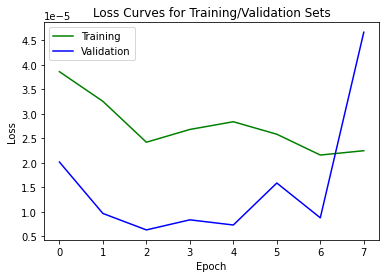

In [44]:
from functions import plot_loss_curves
plot_loss_curves(history_cfis.history, figname="FiveTrainingTilesCFIS_CUSTLOSS_u-r_5tiles.png")

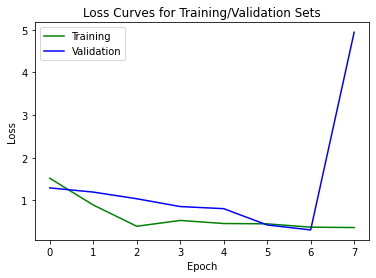

In [20]:
from functions import plot_loss_curves
plot_loss_curves(history_cfis.history, figname="FiveTrainingTilesCFIS_CUSTLOSS_ronly.png")

In [45]:
test_index = 13
sources_test_cfis= get_test_cutouts(test_index, 50, CUTOUT_SIZE, "cfis")
#sources_test_ps1,  weights_test_ps1  = get_test_cutouts(test_index, 50, CUTOUT_SIZE, "ps1")

In [46]:
decoded_imgs_cfis = autoencoder_cfis.predict(sources_test_cfis)
residuals_cfis = sources_test_cfis - decoded_imgs_cfis

In [31]:
sources_test_cfis.shape

(50, 128, 128, 2)

In [47]:
def plot_images(images, figname, bands, start=0):
    #plots source, reconstructed and residuals for 1 image (start = index) for all bands
    fig, axes = plt.subplots(images.shape[0],len(bands), figsize=(2,20))
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.45)
    for row in range(images.shape[0]):
        for col in range(len(bands)):
            norm = ImageNormalize(images[row,:,:,col], interval=ZScaleInterval())
            im = axes[row][col].imshow(images[row,:,:,col], norm=norm)
            #fig.colorbar(im, fraction=0.045, ax=axes[row][col])
            if row == 0:
                axes[row][col].set_title(bands[col])
    plt.savefig("../Plots/" + figname)

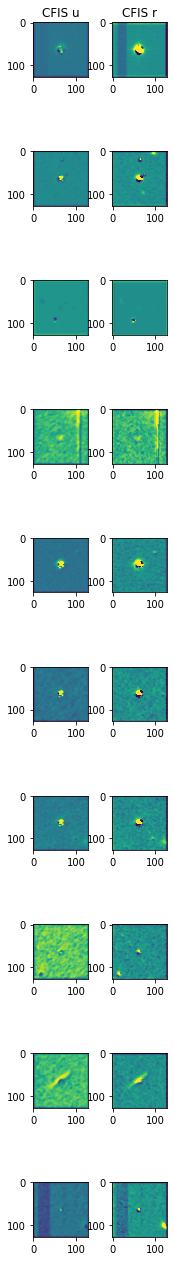

In [48]:
plot_images(decoded_imgs_cfis[:10,:,:,:], "Reconstructed Cutouts 185.270 with Cust Loss r-u.png", bands=["CFIS u", "CFIS r"], start=2)

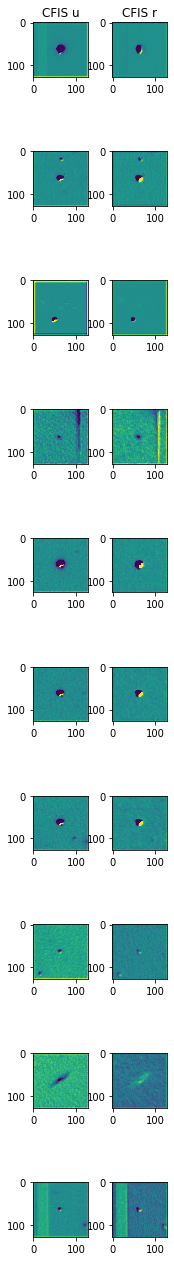

In [42]:
plot_images(decoded_imgs_cfis[:10,:,:,:], "Reconstructed Cutouts 185.270 with Cust Loss.png", bands=["CFIS u", "CFIS r"], start=2)

# Try with PS1

In [19]:
test_index = 13
cutout_size = 128

In [20]:
sources_test_ps1 = get_test_cutouts(test_index, 50, CUTOUT_SIZE, "ps1")

In [21]:
autoencoder_ps1 = create_autoencoder2((CUTOUT_SIZE, CUTOUT_SIZE, 3))
autoencoder_ps1.compile(optimizer="adam", loss=masked_MSE_with_uncertainty)